In [1]:
"""
-> Load preprocessed data OK
-> Write a function that takes as input selected chunk id for each questions and ground truth OK
-> Write the different evaluation metrics (accuracy, precision, recall, f1, ?mrr?, map) OK
"""
from utils.evaluation import evaluate_retrieval

In [2]:
## read jsonl file
import json
file_path = 'processed_data/evaluation_dataset.json'
dataset = []
with open(file_path, 'r') as file:
    dataset = json.loads(file.read())
    

In [3]:
ground_truth = dataset["questions"] #type: ignore

#### Let's try with a simple example on the dataset using llama index with and without cohere rerank

In [6]:
from llama_index.core.schema import TextNode
chunks = dataset['chunks'] #type: ignore
nodes = []
for key, value in chunks.items():
    node = TextNode(
        text=value,
    )
    src_doc_idx = key
    node.metadata['src_doc_idx'] = src_doc_idx
    nodes.append(node)

In [7]:
from llama_index.core import VectorStoreIndex
index = VectorStoreIndex(nodes)

In [17]:
from llama_index.postprocessor.cohere_rerank import CohereRerank
import os

api_key = os.environ["COHERE_API_KEY"]
cohere_rerank = CohereRerank(api_key=api_key, top_n=10)

In [18]:
retriever = index.as_retriever(similarity_top_k=10)
retriever_w_reranker = index.as_query_engine(
    similarity_top_k=20,
    node_postprocessors=[cohere_rerank],
)

In [19]:
import tqdm
from llama_index.core.schema import QueryBundle
selected_chunk_ids = []
selected_chunk_ids_w_reranker = []
for question in tqdm.tqdm(dataset["questions"]):
    if len(question["chunk_ids"]) == 0 or len(question["chunk_ids"]) > 5:
        continue
    query_bundle = QueryBundle(query_str=question["question"] + "?")
    chunks = retriever.retrieve(query_bundle)
    chunks_w_reranker = retriever_w_reranker.retrieve(query_bundle)
    selected_chunk_ids.append({
        "question": question["question"], 
        "chunk_ids": [chunk.metadata["src_doc_idx"]
                    for chunk in chunks]})
    selected_chunk_ids_w_reranker.append({
        "question": question["question"], 
        "chunk_ids": [chunk.metadata["src_doc_idx"]
                    for chunk in chunks_w_reranker]})

100%|██████████| 200/200 [05:12<00:00,  1.56s/it]


In [20]:
results = evaluate_retrieval(ground_truth, selected_chunk_ids) #type: ignore FIXME
results_w_reranker = evaluate_retrieval(ground_truth, selected_chunk_ids_w_reranker) #type: ignore FIXME

Plot saved to retrieval_comparison_with_custom_chunking_10.png


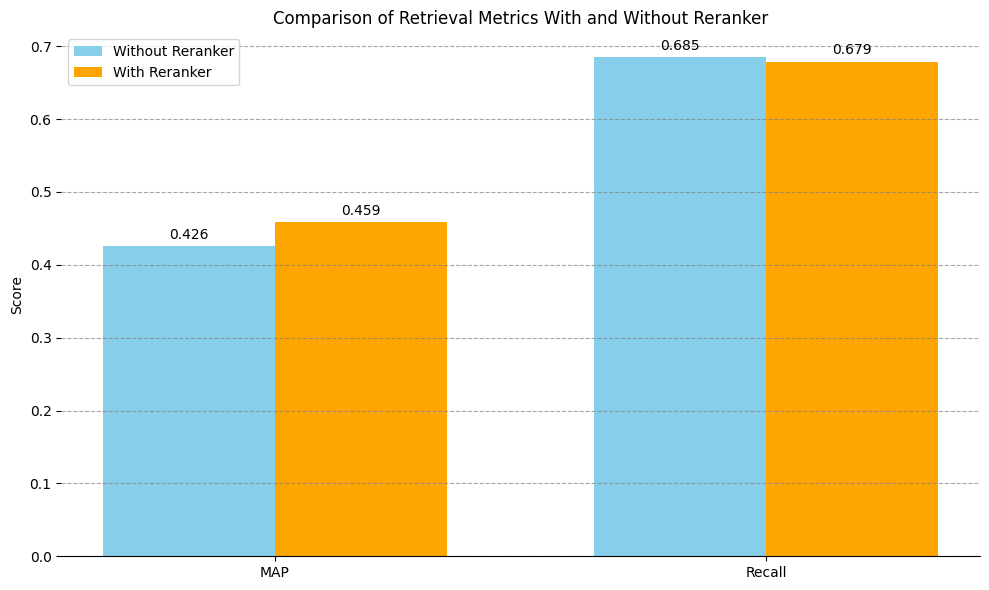

In [21]:
from utils.plotting import plot_retrieval_comparison
plot_retrieval_comparison(results, results_w_reranker, "retrieval_comparison_with_custom_chunking_10.png")